In [1]:
import urllib3
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def download_data(url):
    urllib3.disable_warnings()
    http = urllib3.PoolManager()
    resp = http.request('GET', url)
    return resp.data.decode('utf-8')

In [3]:
def parse_coinmetrics_data(input_data):
    nmap = {'mcap': 4, 'price': 5, 'rcap': 7, 'coins': 8}
    output_data = list()
    for line in input_data.split('\n'):
        array = line.split(',')
        if array[0] != 'date' and len(array) > 8:
            sample = dict()
            for name in nmap:
                try:
                    sample[name] = float(array[nmap[name]])
                except ValueError:
                    sample[name] = None
            output_data.append(sample)
    return output_data

In [4]:
def parse_pastebin_data(input_data):
    output_data = list()
    # Make up for six days of missing data
    for i in range(6):
        sample = {'price': 0}
        output_data.append(sample)
    for line in input_data.split('\n'):
        array = line.split('\t')
        sample = dict()
        if len(array) > 1:
            sample['price'] = float(array[1])
            output_data.append(sample)
    return output_data

In [5]:
def merge_data(cm_data, pb_data):
    output_data = list()
    total_supply = 0
    cumulative_cap = 0
    for i in range(len(cm_data)):
        sample = dict()
        # Get price from bm_data if not available in cm_data
        if not cm_data[i]['price']:
            sample['price'] = pb_data[i]['price']
        else:
            sample['price'] = cm_data[i]['price']
        # Accumulate total supply from daily supply:
        if cm_data[i]['coins']:
            total_supply += cm_data[i]['coins']
        sample['total_supply'] = float(total_supply)
        # Calculate market cap if not available in cm_data
        if not cm_data[i]['mcap']:
            sample['mcap'] = sample['price'] * sample['total_supply']
        else:
            sample['mcap'] = cm_data[i]['mcap']
        # Calulate cumulative market cap and average cumulative market cap
        cumulative_cap += sample['mcap']
        if i != 0:
            sample['acap'] = cumulative_cap/i
        else:
            sample['acap'] = 0
        # Get realized cap straight from cm_data
        sample['rcap'] = cm_data[i]['rcap']
        # Calculate delta cap
        sample['dcap'] = sample['rcap'] - sample['acap']
        # Calculate delta cap / realized cap ratio
        if sample['rcap'] != 0:
            sample['drr'] = sample['dcap'] / sample['rcap']
        else:
            sample['drr'] = None
        output_data.append(sample)
    return output_data

In [6]:
def gather_data():
    url = 'https://coinmetrics.io/data/ltc.csv'
    raw_cm_data = download_data(url)
    cm_data = parse_coinmetrics_data(raw_cm_data)

    url = 'https://pastebin.com/raw/k2vG2XMf'
    raw_pb_data = download_data(url)
    pb_data = parse_pastebin_data(raw_pb_data)

    return merge_data(cm_data, pb_data)

In [7]:
def plot_data(data):
    time = list()
    mcap = list()
    rcap = list()
    dcap = list()
    drr = list()
    t = 0
    for sample in data:
        time.append(t-1)
        mcap.append(sample['mcap'])
        rcap.append(sample['rcap'])
        dcap.append(sample['dcap'])
        drr.append(sample['drr'])
        t += 1
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.set_yscale('log')
  
    ax1.plot(time, mcap, color='dodgerblue')
    ax1.plot(time, rcap, color='dimgrey', alpha=0.9)
    ax1.plot(time, dcap, color='dimgrey', alpha=0.9)
    ax2.plot(time, drr, color='lightgrey', alpha=0.9)
    ax1.set_xlabel('Days since 2011-10-08')
    ax1.set_ylabel('Market/Realized/Delta Cap (USD)')
    ax2.set_ylabel('Delta Cap to Realized Cap Ratio')
    ax2.set_ylim(0.5,1.0)
    
    ax2.axhline(y=0.87, color='lightgrey', linestyle='--', alpha=0.9)
    plt.title('Litecoin bubble top prediction through delta cap / realized cap convergence')
    plt.show()


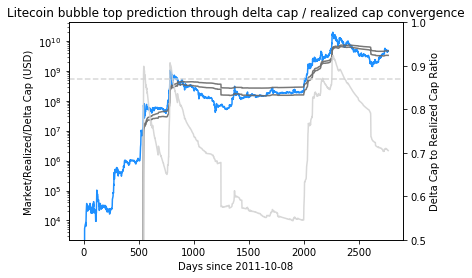

In [8]:
data = gather_data()
plot_data(data)